<a href="https://colab.research.google.com/github/SeydouWane/tuberculose/blob/main/Annotation_d'un_jeu_de_donn%C3%A9es_d'images_microscopiques_de_frottis_sanguins_provenant_de_patients_atteints_de_dr%C3%A9panocytose_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Annotation d'un jeu de données d'images microscopiques de frottis sanguins provenant de patients atteints de drépanocytose**

La drépanocytose est une maladie génétique affectant l'hémoglobine, conduisant à une déformation des globules rouges.

Les globules rouges normaux ont une forme de disque biconcave qui leur permet de circuler facilement à travers les vaisseaux sanguins. Cependant, en raison de la présence de l'hémoglobine S, les globules rouges des personnes atteintes de drépanocytose peuvent se déformer et prendre une forme de faucille ou de croissant lorsqu'ils sont privés d'oxygène ou exposés à des conditions de stress. Cette déformation rend les globules rouges rigides et moins capables de circuler efficacement dans les vaisseaux sanguins.


Pour diagnostiquer cette condition, l'analyse d'images de frottis sanguins microscopiques est cruciale. Cependant, cette tâche nécessite une annotation précise des images pour former des modèles d'intelligence artificielle capables d'identifier les caractéristiques distinctives de la maladie. Dans ce projet, nous avons acquis un jeu de données d'images de frottis sanguins provenant de patients atteints de drépanocytose. Nous avons ensuite suivi un processus en deux étapes pour annoter et analyser ces images.



# I. ACQUISITION DE LA BASE DE DONNEES


Nous avons une base de données composées de 106 images

# II. PRE-TRAITEMENT DES DONNEES

## 0. Connexion de Colab et du **Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Chargement des Bibliothéques

In [6]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2
import time
import numpy as np
import os
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


## 2. GrayScale

Cette étape nous permet de visualiser visuellement l'effet de la conversion en niveaux de gris sur l'image d'origine, tout en quantifiant le temps nécessaire pour cette opération. Cela nous aide à mieux comprendre les performances de notre algorithme de traitement d'image et à optimiser le processus si nécessaire.

Temps d'exécution de la conversion en niveaux de gris : 0.026830196380615234 secondes


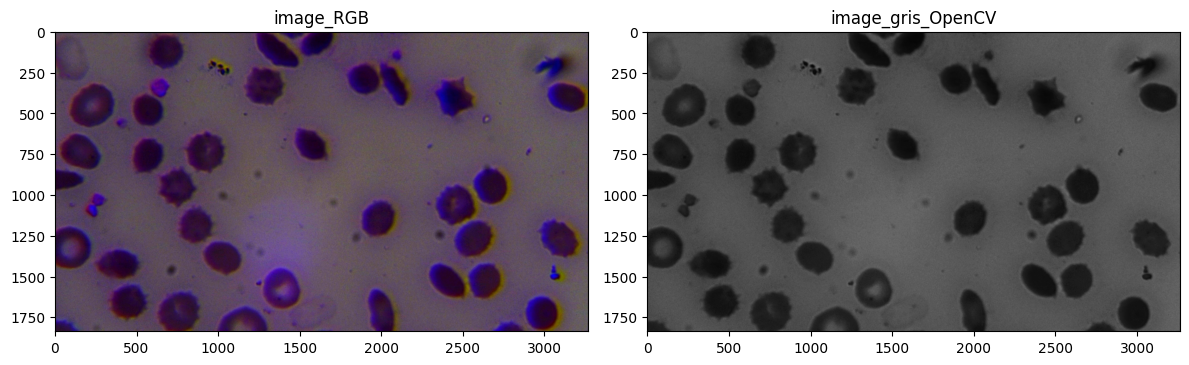

In [7]:
# chargement de l'image
image = cv2.imread("/content/drive/MyDrive/Projet_Big_Data/Data_set /Opta-Tech_338.jpg")

# Evaluation du temps d'exécution
start_time = time.time()

# Convertir l'image en niveau de gris
image_gris_opencv = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Afficher le temps d'exécution
print("Temps d'exécution de la conversion en niveaux de gris : %s secondes" % (time.time() - start_time))

# Affichage des images
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('image_RGB')

ax2.imshow(cv2.cvtColor(image_gris_opencv, cv2.COLOR_BGR2RGB))
ax2.set_title('image_gris_OpenCV')

fig.tight_layout()
plt.show()

## 3. DENOISING

### Les METRIQUES

Nous avons utilisé quatres 4 métriques pour évaluer l'efficacité de notre algorithme de débruitage.
Ces métriques nous permettent d'évaluer objectivement la qualité des images débruitées et de comparer différents algorithmes de débruitage pour choisir celui qui donne les meilleurs résultats pour notre application spécifique de détection de la drépanocytose.
Nous avons:

1. **MSE (Mean Squared Error - Erreur quadratique moyenne)** :
   - L'erreur quadratique moyenne mesure la moyenne des carrés des différences pixel à pixel entre l'image d'origine et l'image débruitée. Plus le MSE est faible, plus l'image débruitée est proche de l'image d'origine.


```
           # mse = np.mean((img - denoised_img) ** 2)
```



2. **PSNR (Peak Signal-to-Noise Ratio - Rapport signal sur bruit maximal)** :
   - Le PSNR mesure la qualité de l'image débruitée en comparant le niveau maximal de signal à la puissance du bruit de l'image. Il est exprimé en décibels (dB) et plus la valeur de PSNR est élevée, meilleure est la qualité de l'image débruitée.


```
            # psnr = cv2.PSNR(img, denoised_img)
```



3. **MAE (Mean Absolute Error - Erreur absolue moyenne)** :
   - L'erreur absolue moyenne est la moyenne des valeurs absolues des différences pixel à pixel entre l'image d'origine et l'image débruitée. Comme pour le MSE, un MAE plus faible indique une meilleure performance de débruitage.



```
            # mae = np.mean(np.abs(img - denoised_img))
```



4. **MSSIM (Mean Structural Similarity Index - Indice de similarité structurelle moyen)** :
   - Le MSSIM mesure la similarité structurelle entre deux images. Il évalue la qualité de l'image débruitée en tenant compte de la luminance, du contraste et de la structure. Un MSSIM proche de 1 indique une forte similarité structurelle entre les images.


```
            # ssim_score, _ = ssim(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.cvtColor(denoised_img, cv2.COLOR_BGR2GRAY), full=True)

```



Dans notre code, nous avons calculé ces métriques pour chaque image débruitée en utilisant l'algorithme de débruitage gaussien et l'algorithme de débruitage médian. Ensuite, nous avons calculé les moyennes de ces métriques sur toutes les images débruitées pour évaluer globalement les performances des deux algorithmes de débruitage.



### Application du filtre gaussien



Le filtre gaussien fonctionne en convoluant l'image avec un noyau gaussien. Ce noyau est une fonction gaussienne bidimensionnelle qui est utilisée pour pondérer les pixels de l'image.
Les principaux paramètres de ce filtre sont la taille du noyau et l'écart-type. La taille du noyau contrôle la taille de la zone sur laquelle l'effet de lissage est appliqué, tandis que l'écart-type contrôle la quantité de flou appliquée à l'image.

In [7]:
def denoise_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Initialisation des totaux pour les métriques
    total_mse = 0
    total_psnr = 0
    total_mae = 0
    total_mssim = 0  # Ajout de la variable pour MSSIM

    # Boucle sur toutes les images dans le dossier d'entrée
    for filename in os.listdir(input_folder):
        if filename.endswith('.jpg'):
            img_path = os.path.join(input_folder, filename)
            img = cv2.imread(img_path)

            # Application du filtre gaussien
            denoised_img = cv2.GaussianBlur(img, (5, 5), 0)  # Taille du noyau (5x5) et écart-type (0)

            # Enregistrement de l'image débruitée
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, denoised_img)

            # Calcul de l'erreur quadratique moyenne (MSE)
            mse = np.mean((img - denoised_img) ** 2)

            # Calcul du PSNR (Peak Signal-to-Noise Ratio)
            psnr = cv2.PSNR(img, denoised_img)

            # Calcul de l'erreur absolue moyenne (MAE)
            mae = np.mean(np.abs(img - denoised_img))

            # Calcul du MSSIM (Mean Structural Similarity Index)
            ssim_score, _ = ssim(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.cvtColor(denoised_img, cv2.COLOR_BGR2GRAY), full=True)

            # Affichage des métriques pour chaque image
            print(f"{filename} débruitée et enregistrée avec succès.")
            print(f"MSE: {mse:.2f}, PSNR: {psnr:.2f}, MAE: {mae:.2f}, MSSIM: {ssim_score:.2f}\n")

            # Ajout des métriques aux totaux
            total_mse += mse
            total_psnr += psnr
            total_mae += mae
            total_mssim += ssim_score

    # Calcul des moyennes des métriques sur toutes les images
    num_images = len([filename for filename in os.listdir(input_folder) if filename.endswith('.jpg')])
    avg_mse_gaussien = total_mse / num_images
    avg_psnr_gaussien = total_psnr / num_images
    avg_mae_gaussien = total_mae / num_images
    avg_mssim_gaussien = total_mssim / num_images

    print(f"MSE moyen: {avg_mse_gaussien:.2f}")
    print(f"PSNR moyen: {avg_psnr_gaussien:.2f}")
    print(f"MAE moyen: {avg_mae_gaussien:.2f}")
    print(f"MSSIM moyen: {avg_mssim_gaussien:.2f}")


# Chemins d'accès aux dossiers d'entrée et de sortie
input_folder = '/content/drive/MyDrive/Projet_Big_Data/Data_set '
output_folder = '/content/drive/MyDrive/Projet_Big_Data/Filtre_gaussien'

# Appeler la fonction pour débruitage et évaluation des images
denoise_images(input_folder, output_folder)


Opta-Tech_466.jpg débruitée et enregistrée avec succès.
MSE: 0.86, PSNR: 48.78, MAE: 67.66, MSSIM: 0.99

Opta-Tech_449.jpg débruitée et enregistrée avec succès.
MSE: 0.72, PSNR: 49.56, MAE: 62.22, MSSIM: 0.99

Opta-Tech_459.jpg débruitée et enregistrée avec succès.
MSE: 0.74, PSNR: 49.43, MAE: 63.30, MSSIM: 0.99

Opta-Tech_465.jpg débruitée et enregistrée avec succès.
MSE: 0.65, PSNR: 50.00, MAE: 59.49, MSSIM: 0.99

Opta-Tech_461.jpg débruitée et enregistrée avec succès.
MSE: 0.84, PSNR: 48.88, MAE: 67.11, MSSIM: 0.99

Opta-Tech_469.jpg débruitée et enregistrée avec succès.
MSE: 0.86, PSNR: 48.71, MAE: 67.92, MSSIM: 0.99

Opta-Tech_446.jpg débruitée et enregistrée avec succès.
MSE: 0.78, PSNR: 49.21, MAE: 64.56, MSSIM: 0.99

Opta-Tech_467.jpg débruitée et enregistrée avec succès.
MSE: 0.83, PSNR: 48.92, MAE: 66.53, MSSIM: 0.99

Opta-Tech_439.jpg débruitée et enregistrée avec succès.
MSE: 0.74, PSNR: 49.44, MAE: 63.45, MSSIM: 0.99

Opta-Tech_474.jpg débruitée et enregistrée avec succès.

## Application du filtre Médian

Le filtre médian consiste à parcourir l'image pixel par pixel et à remplacer la valeur de chaque pixel par la valeur médiane des pixels voisins définis par une fenêtre de taille spécifique (par exemple, une fenêtre de 3x3 ou 5x5).
Il est particulièrement efficace pour supprimer les pixels aberrants ou les impulsions dans une image, car il remplace les valeurs aberrantes par des valeurs plus représentatives de leur voisinage.

In [9]:
def denoise_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    #Initialisation
    total_mse = 0
    total_psnr = 0
    total_mae = 0
    total_mssim = 0  # Nouvelle métrique MSSIM

    #Boucle sur toutes les images dans le dossier d'entrée
    for filename in os.listdir(input_folder):
        if filename.endswith('.jpg'):
            img_path = os.path.join(input_folder, filename)
            img = cv2.imread(img_path)

            # Le filtre médian
            denoised_img = cv2.medianBlur(img, 5)

            # Sauvegarde des images débruitées
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, denoised_img)

            #Calcul de MSE
            mse = np.mean((img - denoised_img) ** 2)

            #Calcul du PSNR
            psnr = cv2.PSNR(img, denoised_img)

            #Calcul de MAE
            mae = np.mean(np.abs(img - denoised_img))

            # Calcul de MSSIM
            ssim_score, _ = ssim(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.cvtColor(denoised_img, cv2.COLOR_BGR2GRAY), full=True)

            # Affichage des métriques pour chaque image
            print(f"{filename} débruitée et enregistrée avec succès.")
            print(f"MSE: {mse:.2f}, PSNR: {psnr:.2f}, MAE: {mae:.2f}, MSSIM: {ssim_score:.2f}\n")

            # Ajout des métriques aux totaux
            total_mse += mse
            total_psnr += psnr
            total_mae += mae
            total_mssim += ssim_score

    # Calcul des moyennes des métriques sur toutes les images
    num_images = len([filename for filename in os.listdir(input_folder) if filename.endswith('.jpg')])
    avg_mse_median = total_mse / num_images
    avg_psnr_median = total_psnr / num_images
    avg_mae_median = total_mae / num_images
    avg_mssim_median = total_mssim / num_images

    print(f"MSE moyen: {avg_mse_median:.2f}")
    print(f"PSNR moyen: {avg_psnr_median:.2f}")
    print(f"MAE moyen: {avg_mae_median:.2f}")
    print(f"MSSIM moyen: {avg_mssim_median:.2f}")


# Chemins d'accès aux dossiers d'entrée et de sortie
input_folder = r'/content/drive/MyDrive/Projet_Big_Data/Data_set '
output_folder = r'/content/drive/MyDrive/Projet_Big_Data/Filtre_median'

# Appel de la fonction
denoise_images(input_folder, output_folder)


Opta-Tech_466.jpg débruitée et enregistrée avec succès.
MSE: 1.68, PSNR: 45.88, MAE: 78.20, MSSIM: 0.98

Opta-Tech_449.jpg débruitée et enregistrée avec succès.
MSE: 1.37, PSNR: 46.76, MAE: 74.52, MSSIM: 0.98

Opta-Tech_459.jpg débruitée et enregistrée avec succès.
MSE: 1.40, PSNR: 46.66, MAE: 74.97, MSSIM: 0.98

Opta-Tech_465.jpg débruitée et enregistrée avec succès.
MSE: 1.20, PSNR: 47.35, MAE: 71.24, MSSIM: 0.99

Opta-Tech_461.jpg débruitée et enregistrée avec succès.
MSE: 1.68, PSNR: 45.87, MAE: 78.59, MSSIM: 0.98

Opta-Tech_469.jpg débruitée et enregistrée avec succès.
MSE: 1.69, PSNR: 45.86, MAE: 78.45, MSSIM: 0.98

Opta-Tech_446.jpg débruitée et enregistrée avec succès.
MSE: 1.49, PSNR: 46.38, MAE: 76.19, MSSIM: 0.98

Opta-Tech_467.jpg débruitée et enregistrée avec succès.
MSE: 1.63, PSNR: 46.01, MAE: 77.82, MSSIM: 0.98

Opta-Tech_439.jpg débruitée et enregistrée avec succès.
MSE: 1.41, PSNR: 46.63, MAE: 75.00, MSSIM: 0.98

Opta-Tech_474.jpg débruitée et enregistrée avec succès.

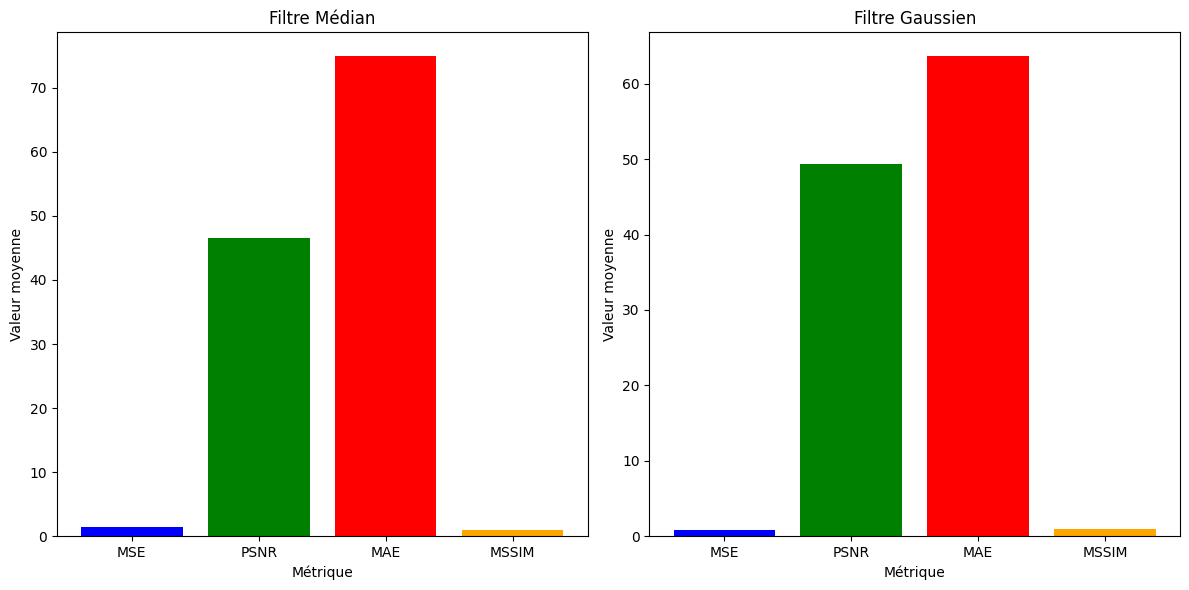

In [8]:
def plot_metrics_comparison(avg_metrics_median, avg_metrics_gaussian):
    metrics = ['MSE', 'PSNR', 'MAE', 'MSSIM']

    # Valeurs moyennes pour le filtre médian
    avg_values_median = list(avg_metrics_median.values())

    # Valeurs moyennes pour le filtre gaussien
    avg_values_gaussian = list(avg_metrics_gaussian.values())

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Diagramme pour le filtre médian
    axs[0].bar(metrics, avg_values_median, color=['blue', 'green', 'red', 'orange'])
    axs[0].set_title('Filtre Médian')
    axs[0].set_xlabel('Métrique')
    axs[0].set_ylabel('Valeur moyenne')

    # Diagramme pour le filtre gaussien
    axs[1].bar(metrics, avg_values_gaussian, color=['blue', 'green', 'red', 'orange'])
    axs[1].set_title('Filtre Gaussien')
    axs[1].set_xlabel('Métrique')
    axs[1].set_ylabel('Valeur moyenne')

    plt.tight_layout()
    plt.show()

# Résultats pour le filtre médian
avg_metrics_median = {'MSE': 1.44, 'PSNR': 46.59, 'MAE': 74.90, 'MSSIM': 0.98}

# Résultats pour le filtre gaussien
avg_metrics_gaussian = {'MSE': 0.76, 'PSNR': 49.34, 'MAE': 63.64, 'MSSIM': 0.99}

# Appel de la fonction pour tracer les diagrammes de comparaison
plot_metrics_comparison(avg_metrics_median, avg_metrics_gaussian)


Après avoir analysé les résultats, nous constatons que le filtre gaussien semble produire des résultats légèrement meilleurs dans l'ensemble.